In [1]:
!pip install tensorflow==2.0.0rc0 &> log
!pip install tensorflow-gpu

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import revnet
import ops
import blocks

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("init_kernel", 3)
  config.add_hparam("init_stride", 1)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 1)
  config.add_hparam("n_res", [1])
  config.add_hparam("filters", [32])
  config.add_hparam("strides", [1])
  config.add_hparam("batch_size", 64)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("init_max_pool", False)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)
  config.add_hparam("last_dense", True)

  config.add_hparam("epochs", 30)
  config.add_hparam("weight_decay", 2e-4)
  
  return config

# Revnet on Imagenette with averagePooling and Dense at the end

In [6]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xzf imagenette2.tgz

--2020-02-24 08:05:37--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.82.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.82.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  35.2MB/s    in 43s     

2020-02-24 08:06:21 (34.6 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [5]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        # with tf.GradientTape() as tape:
        #     logits, _ = model(x_batch_train, training=True)
        #     loss = model.compute_loss(logits=logits, labels=y_batch_train)
        # grads = tape.gradient(loss, model.trainable_variables)
        # optimizer.apply_gradients(zip(grads, model.trainable_variables))

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)
        # if step % 20 == 0:
        #     print('Training accuracy (for one batch) at step %s: %s' % (step, train_acc_metric(y_batch_train, logits).numpy()))
        #     print('Training loss (for one batch) at step %s: %s' % (step, float(loss)))
        #     print('Seen so far: %s samples' % ((step + 1) * config.batch_size))

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()


Epoch: 1
Training loss over epoch: 2.272152900695801
Training acc over epoch: 0.14246489107608795

Val loss over epoch: 2.2275469303131104
Val acc over epoch: 0.17273885011672974

Epoch: 2
Training loss over epoch: 2.122722625732422
Training acc over epoch: 0.2115323692560196

Val loss over epoch: 2.1239538192749023
Val acc over epoch: 0.22726114094257355

Epoch: 3
Training loss over epoch: 2.0692412853240967
Training acc over epoch: 0.24796704947948456

Val loss over epoch: 2.0753021240234375
Val acc over epoch: 0.2557961642742157

Epoch: 4
Training loss over epoch: 2.0210366249084473
Training acc over epoch: 0.27246806025505066

Val loss over epoch: 2.0250163078308105
Val acc over epoch: 0.2929936349391937

Epoch: 5
Training loss over epoch: 1.9832789897918701
Training acc over epoch: 0.2991868257522583

Val loss over epoch: 1.9849029779434204
Val acc over epoch: 0.3133758008480072

Epoch: 6
Training loss over epoch: 1.955523133277893
Training acc over epoch: 0.3210476338863373

Val 

In [0]:
model.save_weights("drive/My Drive/Диплом/small_revnet.hdf5")

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        # with tf.GradientTape() as tape:
        #     logits, _ = model(x_batch_train, training=True)
        #     loss = model.compute_loss(logits=logits, labels=y_batch_train)
        # grads = tape.gradient(loss, model.trainable_variables)
        # optimizer.apply_gradients(zip(grads, model.trainable_variables))

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)
        # if step % 20 == 0:
        #     print('Training accuracy (for one batch) at step %s: %s' % (step, train_acc_metric(y_batch_train, logits).numpy()))
        #     print('Training loss (for one batch) at step %s: %s' % (step, float(loss)))
        #     print('Seen so far: %s samples' % ((step + 1) * config.batch_size))

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()


Epoch: 1
Training loss over epoch: 1.6649614572525024
Training acc over epoch: 0.40278804302215576

Val loss over epoch: 1.789826512336731
Val acc over epoch: 0.3770700693130493

Epoch: 2
Training loss over epoch: 1.6414738893508911
Training acc over epoch: 0.39972540736198425

Val loss over epoch: 1.765004277229309
Val acc over epoch: 0.36840763688087463

Epoch: 3
Training loss over epoch: 1.6302164793014526
Training acc over epoch: 0.3981412947177887

Val loss over epoch: 2.148939371109009
Val acc over epoch: 0.30038216710090637

Epoch: 4
Training loss over epoch: 1.634036898612976
Training acc over epoch: 0.4012039303779602

Val loss over epoch: 1.7034881114959717
Val acc over epoch: 0.43847134709358215

Epoch: 5
Training loss over epoch: 1.606808066368103
Training acc over epoch: 0.4338367283344269

Val loss over epoch: 2.5921871662139893
Val acc over epoch: 0.30904459953308105

Epoch: 6
Training loss over epoch: 1.6014846563339233
Training acc over epoch: 0.40606188774108887

Val 

In [0]:
model.save_weights("drive/My Drive/Диплом/small_revnet.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/small_revnet.hdf5")

In [9]:
max_val_acc = None

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        # with tf.GradientTape() as tape:
        #     logits, _ = model(x_batch_train, training=True)
        #     loss = model.compute_loss(logits=logits, labels=y_batch_train)
        # grads = tape.gradient(loss, model.trainable_variables)
        # optimizer.apply_gradients(zip(grads, model.trainable_variables))

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)
        # if step % 20 == 0:
        #     print('Training accuracy (for one batch) at step %s: %s' % (step, train_acc_metric(y_batch_train, logits).numpy()))
        #     print('Training loss (for one batch) at step %s: %s' % (step, float(loss)))
        #     print('Seen so far: %s samples' % ((step + 1) * config.batch_size))

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/small_revnet.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 1.4163328409194946
Training acc over epoch: 0.4849509000778198

Val loss over epoch: 2.3283772468566895
Val acc over epoch: 0.31821656227111816

Epoch: 2
Training loss over epoch: 1.412247896194458
Training acc over epoch: 0.4760798513889313

Val loss over epoch: 1.9105056524276733
Val acc over epoch: 0.34471338987350464

Epoch: 3
Training loss over epoch: 1.4107301235198975
Training acc over epoch: 0.457492858171463

Val loss over epoch: 1.9421988725662231
Val acc over epoch: 0.39592355489730835

Epoch: 4
Training loss over epoch: 1.4021551609039307
Training acc over epoch: 0.4791424572467804

Val loss over epoch: 1.5928959846496582
Val acc over epoch: 0.4611465036869049

Epoch: 5
Training loss over epoch: 1.402735710144043
Training acc over epoch: 0.48811912536621094

Val loss over epoch: 1.4294030666351318
Val acc over epoch: 0.5271337628364563

Epoch: 6
Training loss over epoch: 1.3935909271240234
Training acc over epoch: 0.47365087270736694

Val 

In [0]:
model.load_weights("drive/My Drive/Диплом/small_revnet.hdf5")

# Gradient-based attack 

In [0]:
from gradient_attack import choose_images, attack

In [8]:
attack_gen = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse",
                                          shuffle=True, batch_size=1, target_size=(224, 224))

Found 3925 images belonging to 10 classes.


Attacked image: 
Logits:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Predicted:  9
Real:  9


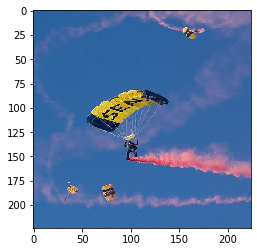

Changing image: 
Logits:  [0.01094633 0.00734755 0.8095836  0.02723462 0.00552433 0.01409791
 0.08346216 0.03044349 0.00961883 0.00174113]
Predicted:  2
Real:  2


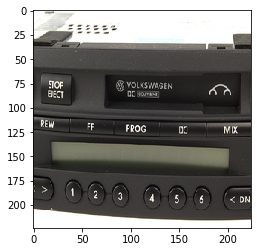

In [9]:
attacked_img, changed_img = choose_images(model, attack_gen=attack_gen, is_custom_model=True, from_logits=True, threshold=0.8)

Loss :  0.13815615
Predict of changing image:  2
Logits of changing image:  [0.02681043 0.01202273 0.7039236  0.04256941 0.01014842 0.02544329
 0.11660811 0.04072122 0.01785955 0.00389327]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


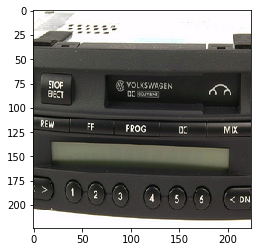

Source image to be changed:


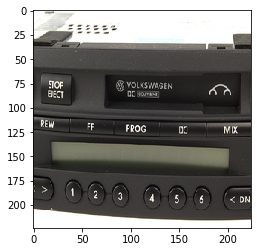

Loss :  0.065398104
Predict of changing image:  9
Logits of changing image:  [0.12937263 0.01418746 0.0544077  0.07939135 0.08557204 0.06344611
 0.14993453 0.08289858 0.16142489 0.1793647 ]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


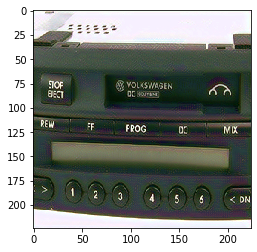

Source image to be changed:


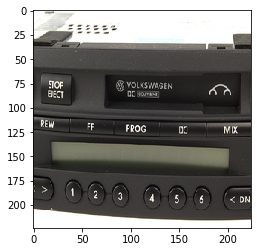

Loss :  0.02234271
Predict of changing image:  9
Logits of changing image:  [0.07532629 0.00510981 0.01075796 0.03934247 0.09876084 0.04897079
 0.08188993 0.0478617  0.09854215 0.49343807]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


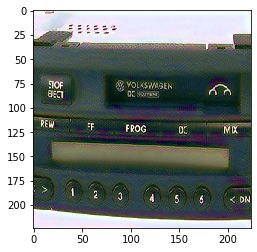

Source image to be changed:


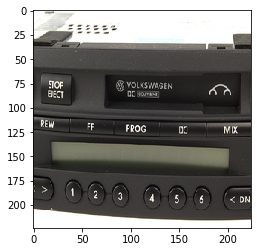

Loss :  0.0056963125
Predict of changing image:  9
Logits of changing image:  [0.04068873 0.00228064 0.00344399 0.01930081 0.07069281 0.03374193
 0.03962003 0.0247474  0.05312074 0.7123629 ]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


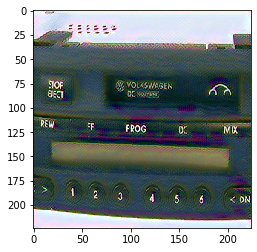

Source image to be changed:


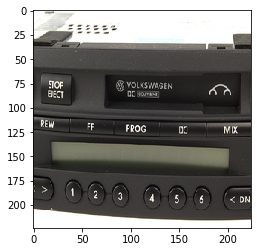

In [10]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign)

Loss :  0.13996862
Predict of changing image:  2
Logits of changing image:  [0.02424251 0.0098351  0.71579814 0.03920865 0.00823242 0.02052087
 0.12222114 0.03846687 0.01792158 0.0035528 ]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


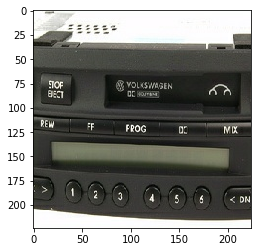

Source image to be changed:


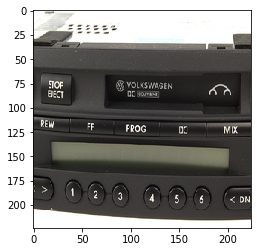

Loss :  0.07553871
Predict of changing image:  8
Logits of changing image:  [0.17456558 0.01544934 0.06757662 0.07926133 0.05550691 0.05271787
 0.16657639 0.06983054 0.18810536 0.13041012]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


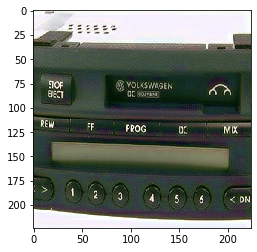

Source image to be changed:


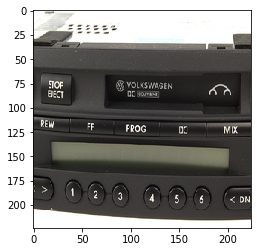

Loss :  0.039056733
Predict of changing image:  9
Logits of changing image:  [0.14475888 0.00850488 0.01758714 0.05029354 0.06887404 0.04931951
 0.10847126 0.04496774 0.14802797 0.35919502]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


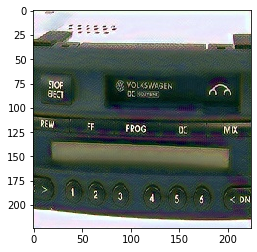

Source image to be changed:


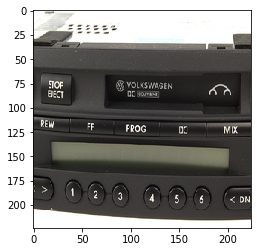

Loss :  0.01652642
Predict of changing image:  9
Logits of changing image:  [0.10079321 0.00518463 0.00770969 0.03097686 0.05751818 0.04362245
 0.06768494 0.02798418 0.09699192 0.5615339 ]
Logits of attacked image:  [9.6108415e-04 3.7316681e-04 3.5150669e-04 2.1229498e-04 5.1934626e-02
 6.2831864e-04 2.1233775e-03 6.6381018e-04 7.8502726e-03 9.3490154e-01]
Changed image:


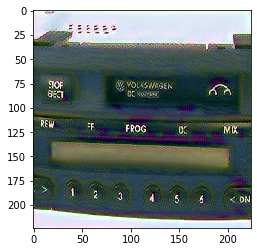

Source image to be changed:


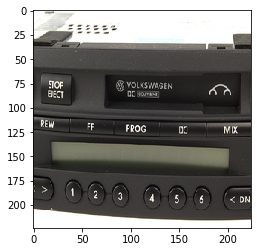

In [11]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign, with_jpeg=True)

Attacked image: 
Logits:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Predicted:  2
Real:  2


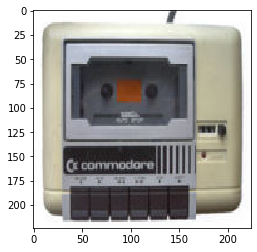

Changing image: 
Logits:  [1.1875734e-05 4.1498723e-05 2.3757542e-02 1.9307699e-03 1.5137172e-02
 1.1399193e-03 4.7197312e-02 9.0062338e-01 1.8112203e-03 8.3493590e-03]
Predicted:  7
Real:  7


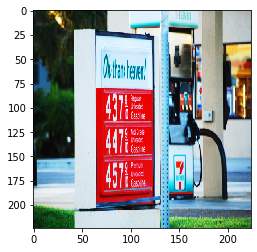

In [12]:
attacked_img, changed_img = choose_images(model, attack_gen=attack_gen, is_custom_model=True, from_logits=True, threshold=0.8)

Loss :  0.14296815
Predict of changing image:  7
Logits of changing image:  [3.6620084e-05 8.6795750e-05 4.0855739e-02 3.8046795e-03 1.7825641e-02
 1.8825344e-03 6.5436848e-02 8.5324228e-01 3.5833362e-03 1.3245524e-02]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


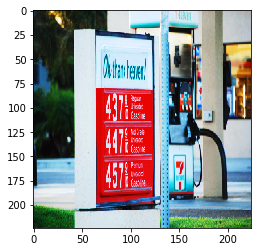

Source image to be changed:


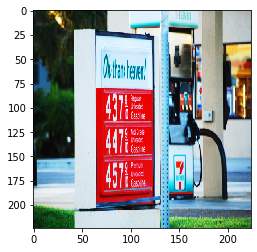

Loss :  0.00378102
Predict of changing image:  2
Logits of changing image:  [2.4112442e-04 5.9727981e-04 7.5876945e-01 1.3223049e-02 1.0410800e-03
 2.9022221e-03 5.1262915e-02 1.4965829e-01 1.8234929e-02 4.0697567e-03]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


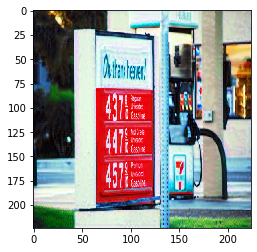

Source image to be changed:


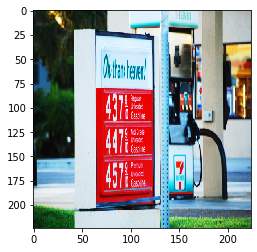

Loss :  5.1837345e-05
Predict of changing image:  2
Logits of changing image:  [1.2826829e-04 1.8471708e-04 8.9869273e-01 7.2097760e-03 1.9809295e-04
 7.4329303e-04 3.4917086e-02 5.1604193e-02 5.5289525e-03 7.9294783e-04]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


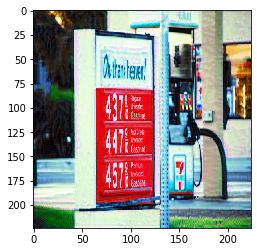

Source image to be changed:


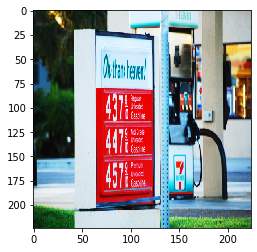

Loss :  7.5782744e-05
Predict of changing image:  2
Logits of changing image:  [1.3128344e-04 1.6556054e-04 8.9463353e-01 7.2573996e-03 2.0482249e-04
 6.6425104e-04 3.8459629e-02 5.2919853e-02 4.8065768e-03 7.5711403e-04]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


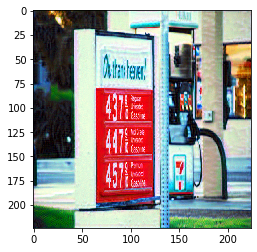

Source image to be changed:


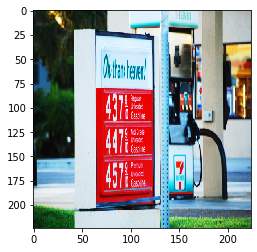

In [13]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign)

Loss :  0.1162374
Predict of changing image:  7
Logits of changing image:  [1.09766414e-04 2.44007737e-04 1.02020524e-01 7.12198718e-03
 1.39694754e-02 2.24618055e-03 1.14630580e-01 7.41090894e-01
 7.28954142e-03 1.12771075e-02]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


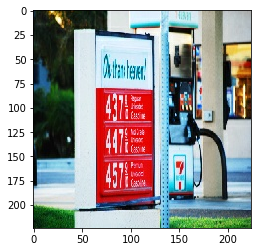

Source image to be changed:


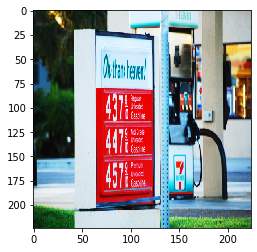

Loss :  0.004796835
Predict of changing image:  2
Logits of changing image:  [2.5013625e-04 6.7411282e-04 7.3773044e-01 1.3300737e-02 1.0761587e-03
 2.4392989e-03 6.8939827e-02 1.5900528e-01 1.3891306e-02 2.6927714e-03]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


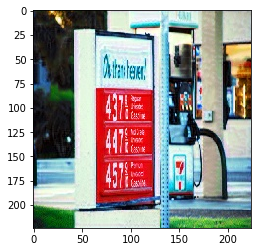

Source image to be changed:


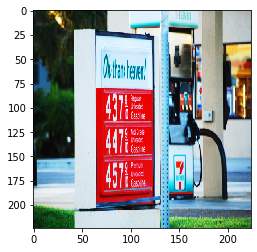

Loss :  0.0003385651
Predict of changing image:  2
Logits of changing image:  [1.5324372e-04 2.7184386e-04 8.6879241e-01 8.4270155e-03 2.6213474e-04
 8.6816784e-04 4.8979040e-02 6.5986305e-02 5.5576921e-03 7.0218928e-04]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


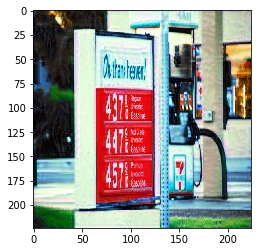

Source image to be changed:


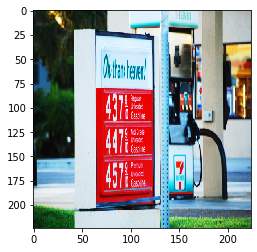

Loss :  0.00040057785
Predict of changing image:  2
Logits of changing image:  [1.6346016e-04 2.5964365e-04 8.6456537e-01 8.6666998e-03 2.7439115e-04
 8.0834772e-04 5.2890230e-02 6.6562459e-02 5.1166527e-03 6.9277576e-04]
Logits of attacked image:  [5.8886486e-05 1.2772528e-03 9.1806364e-01 3.2246967e-03 6.8045704e-04
 1.5813278e-03 3.0796167e-02 4.1747835e-02 2.2461563e-03 3.2353858e-04]
Changed image:


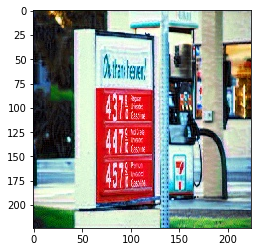

Source image to be changed:


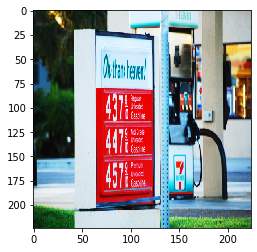

In [14]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign, with_jpeg=True)

Attacked image: 
Logits:  [4.2402893e-02 2.1715472e-02 3.9089099e-04 5.1960801e-03 3.9464883e-03
 1.3733038e-03 7.2054686e-03 4.0530148e-03 8.9156294e-01 2.2153413e-02]
Predicted:  8
Real:  8


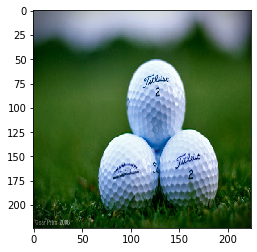

Changing image: 
Logits:  [0.05825839 0.01753624 0.01442976 0.09088487 0.02074202 0.73893887
 0.00960725 0.01509942 0.0195808  0.01492238]
Predicted:  5
Real:  5


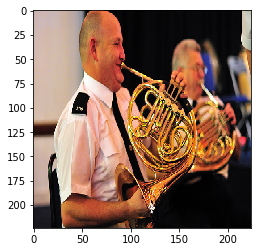

In [19]:
attacked_img, changed_img = choose_images(model, attack_gen=attack_gen, is_custom_model=True, from_logits=True, threshold=0.6)

Loss :  0.110075094
Predict of changing image:  5
Logits of changing image:  [0.10900921 0.02178923 0.0226212  0.14852466 0.03112431 0.57311267
 0.01854461 0.02454866 0.02721219 0.02351327]
Logits of attacked image:  [4.2402893e-02 2.1715472e-02 3.9089099e-04 5.1960801e-03 3.9464883e-03
 1.3733038e-03 7.2054686e-03 4.0530148e-03 8.9156294e-01 2.2153413e-02]
Changed image:


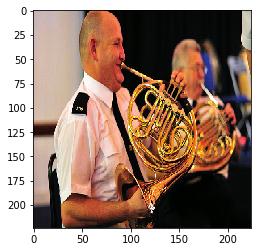

Source image to be changed:


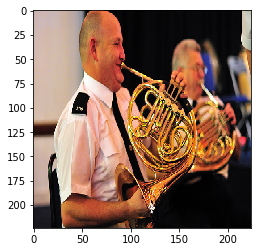

Loss :  0.03495733
Predict of changing image:  8
Logits of changing image:  [0.14252724 0.0317143  0.03121004 0.11522899 0.02820427 0.15136644
 0.01796287 0.03618328 0.34719032 0.09841226]
Logits of attacked image:  [4.2402893e-02 2.1715472e-02 3.9089099e-04 5.1960801e-03 3.9464883e-03
 1.3733038e-03 7.2054686e-03 4.0530148e-03 8.9156294e-01 2.2153413e-02]
Changed image:


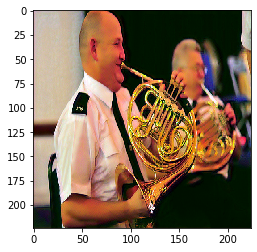

Source image to be changed:


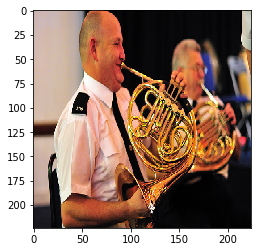

Loss :  0.0019271756
Predict of changing image:  8
Logits of changing image:  [0.0527973  0.0315506  0.01104635 0.02792026 0.00486798 0.04837435
 0.00346898 0.01017654 0.76620024 0.04359736]
Logits of attacked image:  [4.2402893e-02 2.1715472e-02 3.9089099e-04 5.1960801e-03 3.9464883e-03
 1.3733038e-03 7.2054686e-03 4.0530148e-03 8.9156294e-01 2.2153413e-02]
Changed image:


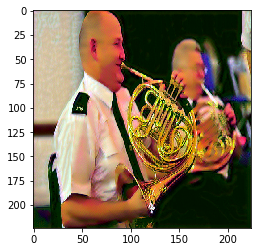

Source image to be changed:


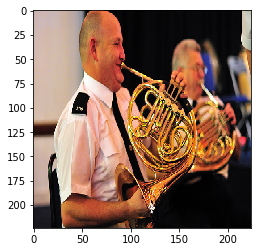

Loss :  0.00022221345
Predict of changing image:  8
Logits of changing image:  [0.06367159 0.02385802 0.00324546 0.01278715 0.0014029  0.01334634
 0.00153843 0.00404173 0.8526307  0.02347763]
Logits of attacked image:  [4.2402893e-02 2.1715472e-02 3.9089099e-04 5.1960801e-03 3.9464883e-03
 1.3733038e-03 7.2054686e-03 4.0530148e-03 8.9156294e-01 2.2153413e-02]
Changed image:


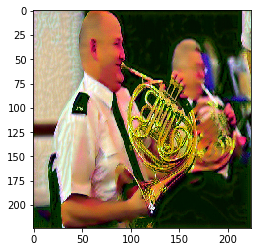

Source image to be changed:


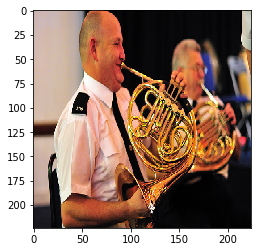

In [20]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign,)

В данных случаях изменение картинки уже сильно заметно

# TODO RevNet without Dense at the end

 # TODO ResNet and compare

In [0]:
def res_net_block(input_data, filters, conv_size):
    x = tf.keras.layers.Conv2D(filters, conv_size, strides=1, activation='relu', use_bias=False, padding='same')(input_data)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, conv_size, strides=1, activation=None, use_bias=False, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, input_data])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [0]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(32, 3, activation=None, padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = res_net_block(x, 32, 3)

# x = tf.keras.layers.Conv2D(32, 3, strides=1, activation='relu', use_bias=False, padding='same')(x)
# x = res_net_block(x, 32, 3)

# x = tf.keras.layers.Conv2D(32, 3, strides=1, activation='relu', use_bias=False, padding='same')(x)
# x = res_net_block(x, 32, 3)

# x = tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu', use_bias=False, padding='same')(x)
# x = res_net_block(x, 64, 3)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10)(x)
res_net_model = tf.keras.Model(inputs, outputs)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        with tf.GradientTape() as tape:
            logits = res_net_model(x_batch_train, training=True)
            loss = tf.keras.backend.sparse_categorical_crossentropy(y_batch_train, logits, from_logits=True)
        grads = tape.gradient(loss, res_net_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, res_net_model.trainable_variables))

        # grads, vars_, loss = res_net_model.compute_gradients(x_batch_train, y_batch_train, training=True)
        # optimizer.apply_gradients(zip(grads, vars_))

        # logits, _ = res_net_model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)
        # if step % 20 == 0:
        #     print('Training accuracy (for one batch) at step %s: %s' % (step, train_acc_metric(y_batch_train, logits).numpy()))
        #     print('Training loss (for one batch) at step %s: %s' % (step, float(loss)))
        #     print('Seen so far: %s samples' % ((step + 1) * config.batch_size))

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = res_net_model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()
